Hola **Robert**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [41]:
#Import libraries
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import time
import math
import xgboost as xgb
from sklearn.metrics import r2_score

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Una buena práctica para cuando tengas que importar varias librerías es seguir el siguiente órden en las mismas:

- Primero todas las librerías que vienen ya con python cómo `datetime`, `os`, `json`, etc.
- Luego de las librerías de Python si las de terceros cómo `pandas`, `scipy`, `numpy`, etc.
- Por último, en el caso de que armes tu propio módulo en tu proyecto esto debería ir en tercer lugar, y recuerda siempre ordenar cada tipo por orden alfabético
    
Para cada sección se deben ordenar en orden alfabético
</div>

In [2]:
# Read csv, convert and assign first column to DateTime format and index of the DF
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
#Print info to observe general data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


No NaN data found.
Data format seems to be correct

In [5]:
#Verify the DataTime is in chronological order
print(df.index.is_monotonic_increasing)

True


## Análisis

<AxesSubplot:xlabel='datetime'>

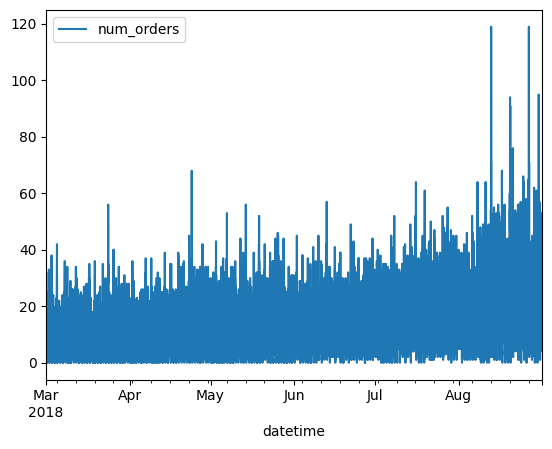

In [6]:
df.plot()

In [7]:
# Initialize a list to store the normality results
normality_results = []

# Iterate over the groups of 6 rows
for i in range(0, len(df), 6):
    group = df['num_orders'].iloc[i:i+6]  # Select a group of 6 rows (always multiples of 6)
    
    # Apply the Shapiro-Wilk normality test
    if len(group) >= 3:  # Ensure the group has at least 3 values
        stat, p = shapiro(group)
        normality_results.append(p > 0.05)  # True if the p-value is greater than 0.05
    else:
        normality_results.append(None)  # Cannot perform the test if there are fewer than 3 data points

# Create a series with the normality results
normality_results = pd.Series(normality_results, index=np.arange(len(normality_results)))


/opt/conda/envs/python3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [8]:
#Count groups that follow a normal distribution
normality_results.value_counts()

True     4048
False     368
dtype: int64

Since most of the groups follow a normal distribution evidenced by Shapiro-Wilk test, the mean is going to be taken as the central tendency measure when resampling

In [9]:
df = df.resample('1H').sum()

In [10]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<AxesSubplot:xlabel='datetime'>

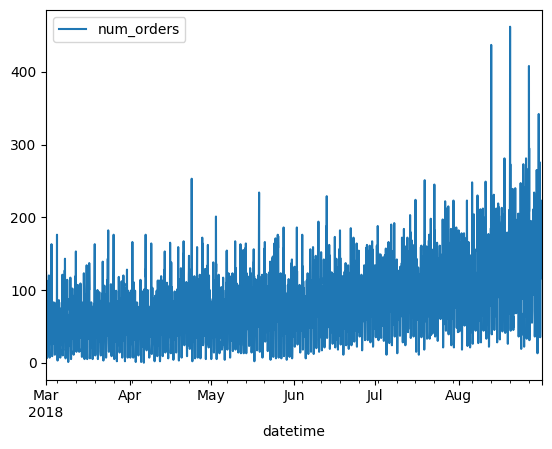

In [11]:
df.plot()

## Formación

In [12]:
decomposed = seasonal_decompose(df, period=24, model='additive')

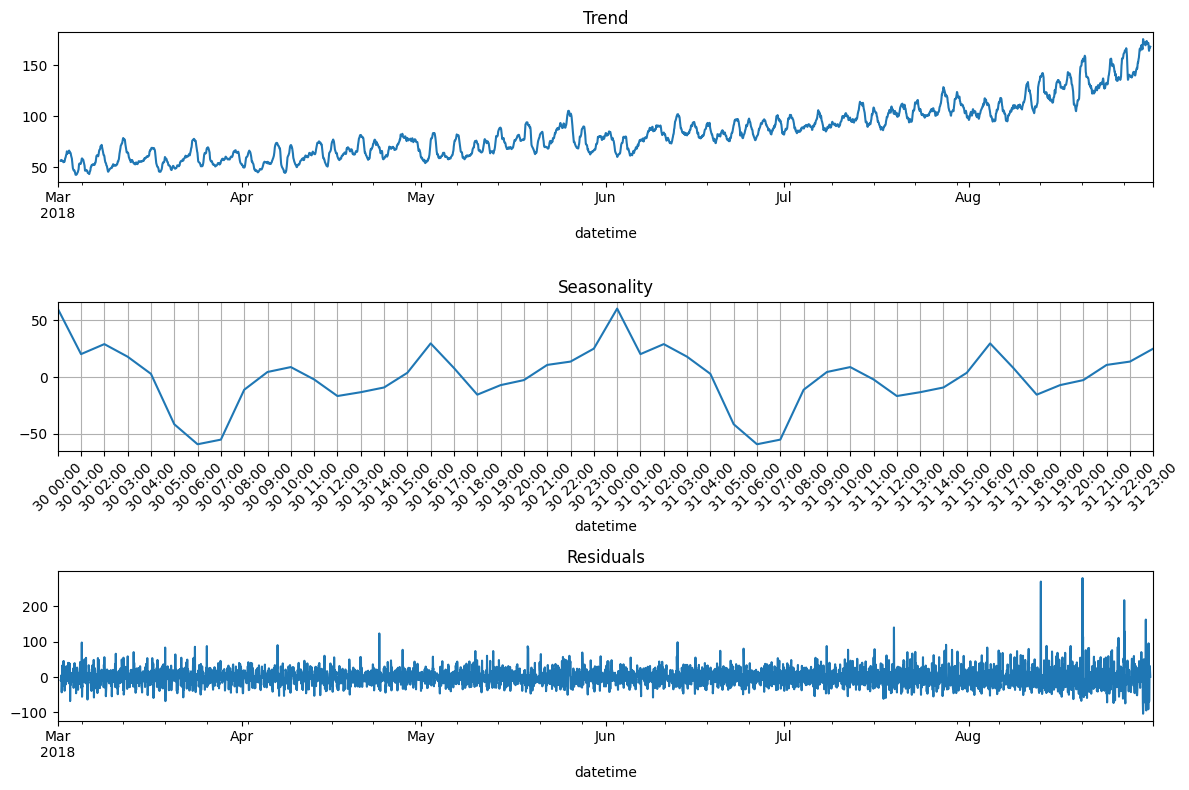

In [13]:
#Analysis of trend and seasonality
plt.figure(figsize=(12, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)  # Add a grid
plt.xlim(('2018-08-30 00:00:00', '2018-08-31 00:00:00')) #Select Time window
ticks = df.loc['2018-08-30':'2018-08-31'].index #Selcet labels period for X axis
labels = ticks.strftime('%d %H:%M') #Select labels for X axis to include date and hour
plt.xticks(ticks=ticks, labels=labels, rotation=45)


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

There is an increase trend of the number of orders per hour in the whole in the 6-month period.
The seasonality shows the peak of number of orders near the midnight and falls down by the start of the active work day.

In [14]:
df['rolling_mean'] = df['num_orders'].rolling(10).mean()

In [15]:
#df['rolling_std'] = df['num_orders'].rolling(10).std()

<AxesSubplot:xlabel='datetime'>

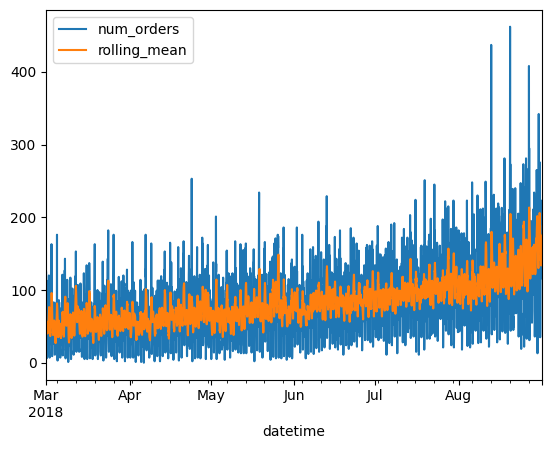

In [16]:
df.plot()

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con las gráficas! Cómo recomendación, siempre trata de redactar la interpretación de las mismas cada que presentas una gráfica
</div>

In [17]:
#Define a function to create calendar, lag and moving average features
def make_features(data, max_lag, rolling_size):
    data['month'] = data.index.month
    data['day_of_month'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()

In [18]:
#Create new features with a 24-h period for the lag and rolling size since this is the window of seasonality
make_features(df, 72, 72)

In [19]:
#Split main DF into train and test subsets
train_df, test_df = train_test_split(df, shuffle=False, test_size=0.1)
#Shuffling is avoided since chronological order will be kept and the test size is the 10% of the DF

In [20]:
train_df.index # train_df starts on '2018-03-01 00:00:00' and ends on '2018-08-13 13:00:00'

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-08-13 04:00:00', '2018-08-13 05:00:00',
               '2018-08-13 06:00:00', '2018-08-13 07:00:00',
               '2018-08-13 08:00:00', '2018-08-13 09:00:00',
               '2018-08-13 10:00:00', '2018-08-13 11:00:00',
               '2018-08-13 12:00:00', '2018-08-13 13:00:00'],
              dtype='datetime64[ns]', name='datetime', length=3974, freq='H')

In [21]:
test_df.index # test_df starts on '2018-08-13 14:00:00' and ends on '2018-08-31 23:00:00'

DatetimeIndex(['2018-08-13 14:00:00', '2018-08-13 15:00:00',
               '2018-08-13 16:00:00', '2018-08-13 17:00:00',
               '2018-08-13 18:00:00', '2018-08-13 19:00:00',
               '2018-08-13 20:00:00', '2018-08-13 21:00:00',
               '2018-08-13 22:00:00', '2018-08-13 23:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=442, freq='H')

In [22]:
#Drop NaN values which were created before the lag and rolling size window
train_df = train_df.dropna()

In [23]:
#Split features and target from train and test Dfs
train_features = train_df.drop(['num_orders'], axis=1)
train_target = train_df['num_orders']
test_features = test_df.drop(['num_orders'], axis=1)
test_target = test_df['num_orders']

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, realizaste los ajustes de las características en el dataset de manera adecuada para obtener un buen desempeño en los entrenamientos
    
</div>

In [24]:
#Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(train_features, train_target)

LinearRegression()

In [25]:
#Loof for the best hyperparameters in a decision tree regressor model
for max_depth in range(1, 6):
    tree_model = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
    tree_model.fit(train_features, train_target)
    train_predictions = tree_model.predict(train_features)
    test_predictions = tree_model.predict(test_features)
    print(f"max_depth = {max_depth} :", mean_squared_error(test_target, test_predictions, squared=False))

max_depth = 1 : 70.59333628922711
max_depth = 2 : 58.67772130047045
max_depth = 3 : 53.30633825163852
max_depth = 4 : 61.417512433665074
max_depth = 5 : 60.189698108856476


In [26]:
# Train a decision tree regressor model with the best hyperparameters found
tree_model = DecisionTreeRegressor(max_depth=4, random_state=12345)
tree_model.fit(train_features, train_target)

DecisionTreeRegressor(max_depth=4, random_state=12345)

In [ ]:
# Define the base model
forest_model = RandomForestRegressor(random_state=54321)

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configure `GridSearchCV`
grid_search = GridSearchCV(
    forest_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)

# Train the model and find the best hyperparameters
grid_search.fit(train_features, train_target)

# Get the best trained model
best_rf = grid_search.best_estimator_

# Evaluate on the test set
forest_test_predictions = best_rf.predict(test_features)
test_rmse = mean_squared_error(test_target, forest_test_predictions, squared=False)

# Display the best hyperparameters and best rmse
print("Best hyperparameters:", grid_search.best_params_)
print("RMSE:", test_rmse)

In [27]:
#Train Random Forest Regressor with the best hyperparameters 
forest_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_leaf=2,
            min_samples_split=2,
            random_state=12345
        )
forest_model.fit(train_features, train_target)

RandomForestRegressor(min_samples_leaf=2, random_state=12345)

In [28]:
# --- Initialize model with reasonable defaults ---
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# --- Training ---
start_train = time.time()
lgb_model.fit(train_features, train_target, categorical_feature='auto')
end_train = time.time()
training_time = end_train - start_train

# --- Prediction ---
start_pred = time.time()
lgb_preds = lgb_model.predict(test_features)
end_pred = time.time()
prediction_time = end_pred - start_pred

# --- RMSE Evaluation ---
rmse_lgb = mean_squared_error(test_target, lgb_preds, squared=False)

# --- Complexity Estimation ---
n = train_features.shape[0]
d = train_features.shape[1]
n_test = test_features.shape[0]
T = lgb_model.n_estimators

# LightGBM training: O(T × n × log n)
train_ops = int(T * n * math.log2(n))

# Prediction: O(T × log n × n_test)
predict_ops = int(T * math.log2(n) * n_test)

# --- Results ---
print("⚡ LightGBM Regressor (default parameters)")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"Training time: {training_time:.4f} seconds")
print(f"Prediction time: {prediction_time:.4f} seconds")
print(f"Theoretical training complexity: O(T × n × log n)")
print(f"Estimated training operations: {train_ops:,}")
print(f"Theoretical prediction complexity: O(T × log n × n_test)")
print(f"Estimated prediction operations: {predict_ops:,}")

⚡ LightGBM Regressor (default parameters)
RMSE: 39.36
Training time: 1.1227 seconds
Prediction time: 0.0028 seconds
Theoretical training complexity: O(T × n × log n)
Estimated training operations: 4,655,085
Theoretical prediction complexity: O(T × log n × n_test)
Estimated prediction operations: 527,305


In [29]:
# Initialize model with default parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=12345,
    n_jobs=-1
)

# --- TRAINING ---
start_train = time.time()
xgb_model.fit(train_features, train_target)
end_train = time.time()
training_time = end_train - start_train

# --- PREDICTION ---
start_pred = time.time()
xgb_preds = xgb_model.predict(test_features)
end_pred = time.time()
prediction_time = end_pred - start_pred

# --- EVALUATION ---
rmse_xgb = mean_squared_error(test_target, xgb_preds, squared=False)

# --- COMPLEXITY ESTIMATION ---
n_train = train_features.shape[0]
n_test = test_features.shape[0]
T = xgb_model.n_estimators

# XGBoost training: O(T × n × log n × d)
d = train_features.shape[1]
train_ops = int(T * n_train * math.log2(n_train) * d)

# Prediction: O(T × log n × n_test)
predict_ops = int(T * math.log2(n_train) * n_test)

# --- RESULTS ---
print("🌲 XGBoost Regressor (default settings)")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"Training time: {training_time:.4f} seconds")
print(f"Prediction time: {prediction_time:.4f} seconds")
print(f"Theoretical training complexity: O(T × n × log n × d)")
print(f"Estimated training operations: {train_ops:,}")
print(f"Theoretical prediction complexity: O(T × log n × n_test)")
print(f"Estimated prediction operations: {predict_ops:,}")

🌲 XGBoost Regressor (default settings)
RMSE: 39.88
Training time: 3.4319 seconds
Prediction time: 0.0690 seconds
Theoretical training complexity: O(T × n × log n × d)
Estimated training operations: 353,786,478
Theoretical prediction complexity: O(T × log n × n_test)
Estimated prediction operations: 527,305


## Prueba

In [30]:
# Make a prediction with the train_df mean for a Sanity Check
mean_pred = np.ones(test_target.shape) * train_target.mean()

In [31]:
# Calculate the RMSE of the mean prediction
mean_squared_error(test_target, mean_pred, squared=False)

84.4709080778736

In [32]:
# Show the test_df mean the view the relative difference of the RMSE with its mean
test_df['num_orders'].mean()

139.55656108597285

In [33]:
# Make a prediction with the previous hour data for a Sanity Check
previous_pred = test_target.shift()

In [34]:
# Fill the first raw of the test_df prediction with the last row of the train_df
previous_pred.iloc[0] = train_target.iloc[-1]

In [35]:
# Calculate the RMSE of the previous hour data prediction
mean_squared_error(test_target, previous_pred, squared=False)

58.856486242815066

The previous_pred works much better than the mean_pred

In [36]:
#Make predictions in train and test DF with LR model
lr_train_pred = lr_model.predict(train_features)
lr_test_pred = lr_model.predict(test_features)

print('LR model RMSE')

#Calculate the RMSE for the train_df with the lr_model
print(mean_squared_error(train_target, lr_train_pred, squared=False))

#Calculate the RMSE for the test_df with the lr_model
print(mean_squared_error(test_target, lr_test_pred, squared=False))

LR model RMSE
22.588692390996606
42.473757572399


In [37]:
#Make predictions in train and test DF with tree model
tree_train_pred = tree_model.predict(train_features)
tree_test_pred = tree_model.predict(test_features)

print('tree model RMSE')

#Calculate the RMSE for the train_df with the tree_model
print(mean_squared_error(train_target, tree_train_pred, squared=False))

#Calculate the RMSE for the test_df with the tree_model
print(mean_squared_error(test_target, tree_test_pred, squared=False))

tree model RMSE
24.989525534319988
61.417512433665074


In [38]:
#Make predictions in train and test DF with forest model
forest_train_pred = forest_model.predict(train_features)
forest_test_pred = forest_model.predict(test_features)

print('forest model RMSE')

#Calculate the RMSE for the train_df with the forest_model
print(mean_squared_error(train_target, forest_train_pred, squared=False))

#Calculate the RMSE for the test_df with the forest_model
print(mean_squared_error(test_target, forest_test_pred, squared=False))

forest model RMSE
9.568738075248698
39.52403632189836


In [39]:
#Make predictions in train and test DF with the lgb model
lgb_train_pred = lgb_model.predict(train_features)
lgb_test_pred = lgb_model.predict(test_features)

print('lgb model RMSE')

#Calculate the RMSE for the train_df with the lgb_model
print(mean_squared_error(train_target, lgb_train_pred, squared=False))

#Calculate the RMSE for the test_df with tree_model
print(mean_squared_error(test_target, lgb_test_pred, squared=False))

lgb model RMSE
10.307636958311617
39.36154002536271


In [40]:
#Make predictions in train and test DF with the xgb model
xgb_train_pred = xgb_model.predict(train_features)
xgb_test_pred = xgb_model.predict(test_features)

print('xgb model RMSE')

#Calculate the RMSE for the train_df with the lgb_model
print(mean_squared_error(train_target, xgb_train_pred, squared=False))

#Calculate the RMSE for the test_df with tree_model
print(mean_squared_error(test_target, xgb_test_pred, squared=False))

xgb model RMSE
10.200629423950799
39.8801777515151


In [46]:
#Show the determination coefficient of the best model which was lgb
print(r2_score(train_target, lgb_train_pred))
print(r2_score(test_target, lgb_test_pred))

0.929015673732722
0.5480439958761829


The best ML model was LGB obtaining a RMSE <40 num of orders per hour.
It shows a determination coefficient of 0.55 which means it works more than 50% better than the mean when predicting the values.
Even thoug there is a big difference in the RMSE between the train predictions and the test predictions, the test error complies the objective < 48.

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteracion)</b> <a class=“tocSkip”></a>

Te felicito por el trabajo realizado Robert, aplicaste los procesos adecuados al dataset para darle características nuevas al modelo, con ese proceso aportas significativamente al desempeño del mismo y obtuviste una métrica que supera lo propuesto para este proyecto, continúa con este gran trabajo!
    
   
Este proyecto es uno donde se ve claramente la importancia de darle características o variables a decuadas a los modelos para obtener un correcto desempeño, si quitas o pones más variables el desempeño del modelo variará para bien o para mal según la calidad de las mismas. Saludos!
</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48